# Final Project (part 2)
#### By Shubhankar Kumar

### 2. Timeline Analysis

In [1]:
commits_df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/shubhankark/commits")

In [2]:
commits_df.select("committer").head(5)

[Row(committer=Row(name='Karthik Rajasekaran', email='5ea0f07426fd439ffb5a9e9b6f42da6247ef37fd@microsoft.com', time_sec=1508544992, tz_offset=-420, date=Row(seconds=1508544992, nanos=None))),
 Row(committer=Row(name='unbrace3', email='6b26c749f3dbcee1d9fa0b9794e9e703ecb822d5@gmail.com', time_sec=1462242510, tz_offset=-420, date=Row(seconds=1462242510, nanos=None))),
 Row(committer=Row(name='Greg Schueler', email='4757c2725c0ad867bf62aa1b563f5ff6d0b9b4ee@gmail.com', time_sec=1598395069, tz_offset=-420, date=Row(seconds=1598395069, nanos=None))),
 Row(committer=Row(name='GitHub', email='1505422b2465e9a84f6fdfaa161078890c593f06@github.com', time_sec=1505154726, tz_offset=-420, date=Row(seconds=1505154726, nanos=None))),
 Row(committer=Row(name='Cesar Del Solar', email='3ff33887f666af4c39d94d77e26775e4ac22237b@gmail.com', time_sec=1370329283, tz_offset=-420, date=Row(seconds=1370329283, nanos=None)))]

In [3]:
from pyspark.sql.functions import col, regexp_extract
commits_df = commits_df.withColumn(
    "date",
    col("committer.time_sec")
)
commits_df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|              author|           committer|             subject|             message|           repo_name|      date|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|{Karthik Rajaseka...|{Karthik Rajaseka...|Include props tha...|Include props tha...|[mmitche/buildtoo...|1508544992|
|{unbrace3, 6b26c7...|{unbrace3, 6b26c7...|try php one more ...|try php one more ...|[unbrace3/unbrace...|1462242510|
|{Greg Schueler, 4...|{Greg Schueler, 4...|fix: extra dom el...|fix: extra dom el...|[rundeck/rundeck,...|1598395069|
|{Michael Driscoll...|{GitHub, 1505422b...|Merge pull reques...|Merge pull reques...| [mbdriscoll/indigo]|1505154726|
|{Cesar Del Solar,...|{Cesar Del Solar,...|Trying and failin...|Trying and failin...| [domino14/Webolith]|1370329283|
+--------------------+--------------------+-------------

In [4]:
from pyspark.sql.functions import from_unixtime

commits_df = commits_df.withColumn("timestamp", from_unixtime("date"))
commits_df = commits_df.drop("date")

In [5]:
from pyspark.sql.functions import year
import matplotlib.pyplot as plt

commits_df = commits_df.withColumn("year", year(col("timestamp")))

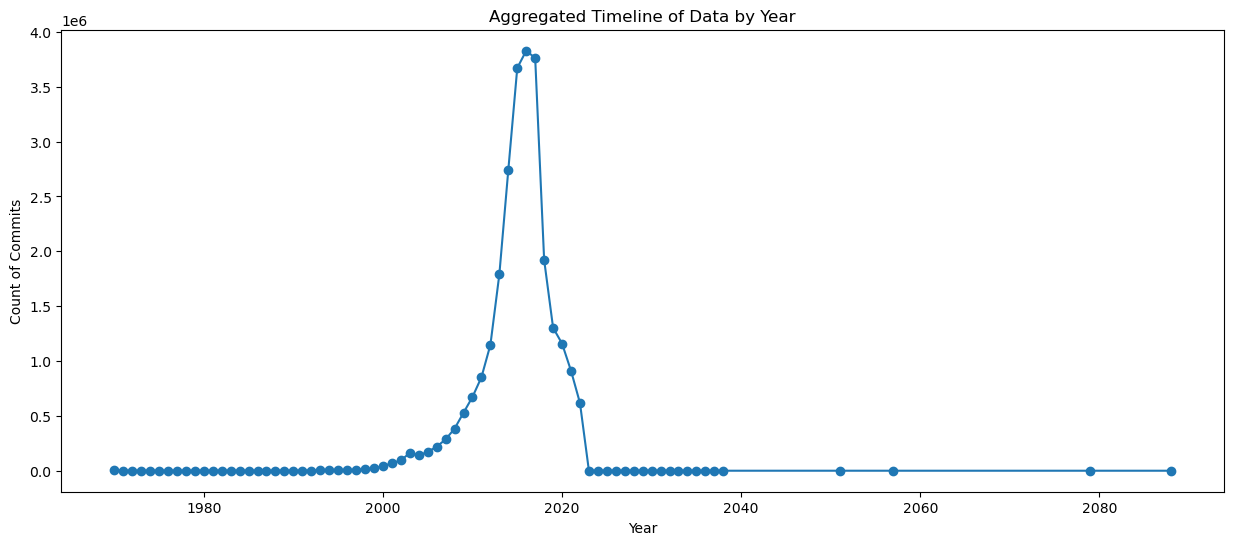

In [6]:
sample_df_commits = commits_df.sample(fraction=0.1, seed=42)

# Aggregating data by year
timeline_data = sample_df_commits.groupBy("year").count().orderBy("year")

aggregated_pd = timeline_data.toPandas()

plt.figure(figsize=(15, 6))
plt.plot(aggregated_pd['year'], aggregated_pd['count'], marker='o')
plt.title('Aggregated Timeline of Data by Year')
plt.xlabel('Year')
plt.ylabel('Count of Commits')
plt.show()

Years before 2000 have very low counts, and years after 2023 make no sense. Hence, I am only keeping data with years between 2000 and 2023.

In [7]:
commits_df_new = commits_df.filter((year("timestamp") >= 2000) & (year("timestamp") <= 2023))

In [8]:
commits_df_new = commits_df_new.drop("year", "month")

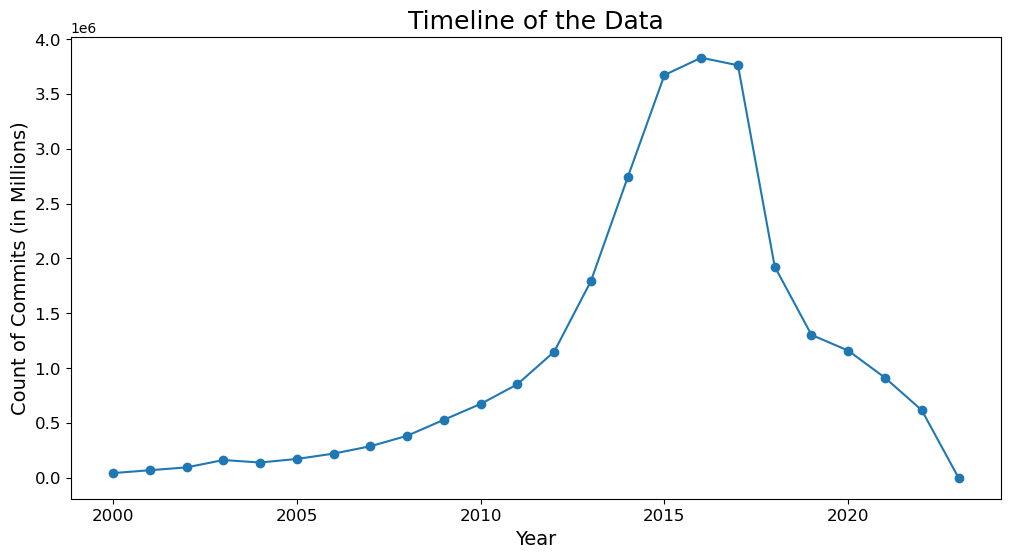

In [9]:
commits_df_new = commits_df_new.withColumn("year", year(col("timestamp")))
sample_df_commits = commits_df_new.sample(fraction=0.1, seed=42)

# Aggregating data by year
timeline_data = sample_df_commits.groupBy("year").count().orderBy("year")

aggregated_pd = timeline_data.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(aggregated_pd['year'], aggregated_pd['count'], marker='o')
plt.title('Timeline of the Data', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Commits (in Millions)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("timeline_plot.png")
plt.show()

There is a peak between 2015 and 2017.

In [10]:
del timeline_data, sample_df_commits, commits_df

### 3. Programming language analysis

In [11]:
languages_df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/shubhankark/languages")

In [12]:
languages_df.show(5)

+-------------------+------------+
|          repo_name|    language|
+-------------------+------------+
|  lemi136/puntovent|   [{C, 80}]|
|     taxigps/nctool| [{C, 4461}]|
|        ahy1/strbuf| [{C, 5573}]|
|nleiten/mod_rpaf-ng|[{C, 30330}]|
|kmcallister/alameda|[{C, 17077}]|
+-------------------+------------+
only showing top 5 rows



In [13]:
from pyspark.sql.functions import explode, sum

# Explode the array of structs to create separate rows for each language
exploded_languages_df = languages_df.select("repo_name", explode("language").alias("language"))

# Aggregate the total number of bytes for each language
aggregated_data = exploded_languages_df.groupBy("language.name").agg(sum("language.bytes").alias("total_bytes"))

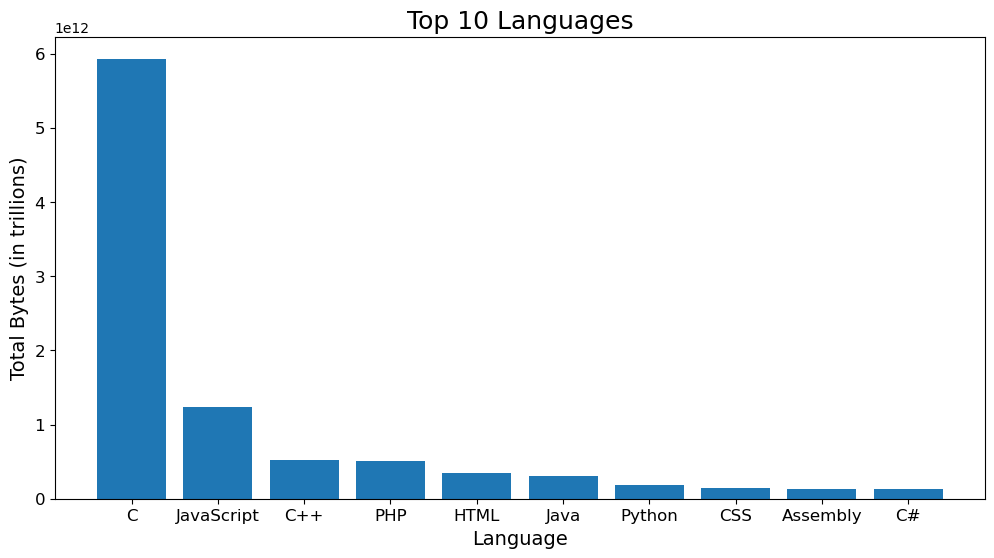

In [14]:
sorted_data = aggregated_data.orderBy(col("total_bytes").desc())

top_10_languages = sorted_data.limit(10)

top_10_pd = top_10_languages.toPandas()

# Plot the bar chart for the top 10 languages
plt.figure(figsize=(12, 6))
plt.bar(top_10_pd['name'], top_10_pd['total_bytes'])
plt.title('Top 10 Languages', fontsize=18)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Total Bytes (in trillions)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("languages_plot.png")
plt.show()

As seen in the bar plot, C is the most popular programming language. JavaScript is a distant second.

### 4. License analysis

In [15]:
licenses_df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/shubhankark/licenses")

In [16]:
unique_licenses = licenses_df.select("license").distinct()
unique_licenses.show()

+------------+
|     license|
+------------+
|   unlicense|
|    lgpl-3.0|
|     cc0-1.0|
|     gpl-2.0|
|bsd-3-clause|
|     epl-1.0|
|     gpl-3.0|
|bsd-2-clause|
|  apache-2.0|
|     mpl-2.0|
|         isc|
|artistic-2.0|
|         mit|
|    agpl-3.0|
|    lgpl-2.1|
+------------+



In [17]:
del unique_licenses

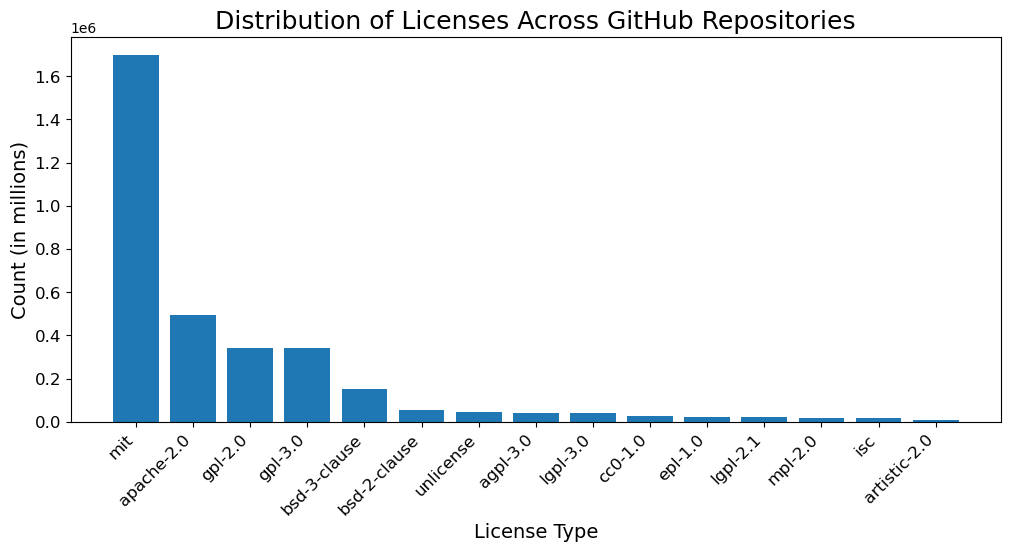

In [18]:
license_distribution = licenses_df.groupBy("license").count().orderBy(col("count").desc())
license_distribution_pd = license_distribution.toPandas()

plt.figure(figsize=(12, 5))
plt.bar(license_distribution_pd['license'], license_distribution_pd['count'])
plt.title('Distribution of Licenses Across GitHub Repositories', fontsize=18)
plt.xlabel('License Type', fontsize=14)
plt.ylabel('Count (in millions)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("license_first_plot.png")
plt.show()

In [19]:
new_languages_df = languages_df.withColumn(
    "language_cleaned",
    col("language.name")
)
new_languages_df = new_languages_df.drop("language")
new_languages_df.show(5)
new_languages_df.printSchema()

+-------------------+----------------+
|          repo_name|language_cleaned|
+-------------------+----------------+
|  lemi136/puntovent|             [C]|
|     taxigps/nctool|             [C]|
|        ahy1/strbuf|             [C]|
|nleiten/mod_rpaf-ng|             [C]|
|kmcallister/alameda|             [C]|
+-------------------+----------------+
only showing top 5 rows

root
 |-- repo_name: string (nullable = true)
 |-- language_cleaned: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [20]:
exploded_languages_df_new = new_languages_df.select("repo_name", explode("language_cleaned").alias("language_cleaned"))

selected_languages = ["C", "C++", "JavaScript", "PHP", "HTML", "Java", "Python", "CSS", "Assembly", "C#"]
filtered_languages_df = exploded_languages_df_new.filter(col("language_cleaned").isin(selected_languages))

merged_df = filtered_languages_df.join(licenses_df, "repo_name", "inner")


# Group by the combination of programming language and license, and count occurrences
association_counts = merged_df.groupBy("language_cleaned", "license").count().orderBy(col("count").desc())

# Show the resulting DataFrame
association_counts.show(truncate=False)

+----------------+----------+------+
|language_cleaned|license   |count |
+----------------+----------+------+
|JavaScript      |mit       |685287|
|CSS             |mit       |458715|
|HTML            |mit       |449004|
|Python          |mit       |208624|
|PHP             |mit       |161595|
|Java            |apache-2.0|148855|
|JavaScript      |apache-2.0|131628|
|HTML            |apache-2.0|119479|
|CSS             |apache-2.0|111135|
|Java            |mit       |97819 |
|JavaScript      |gpl-2.0   |91330 |
|C               |mit       |83891 |
|C++             |mit       |83236 |
|Python          |gpl-3.0   |82362 |
|Python          |apache-2.0|81244 |
|CSS             |gpl-2.0   |78612 |
|JavaScript      |gpl-3.0   |74619 |
|Python          |gpl-2.0   |74253 |
|C#              |mit       |71735 |
|C               |gpl-2.0   |69931 |
+----------------+----------+------+
only showing top 20 rows



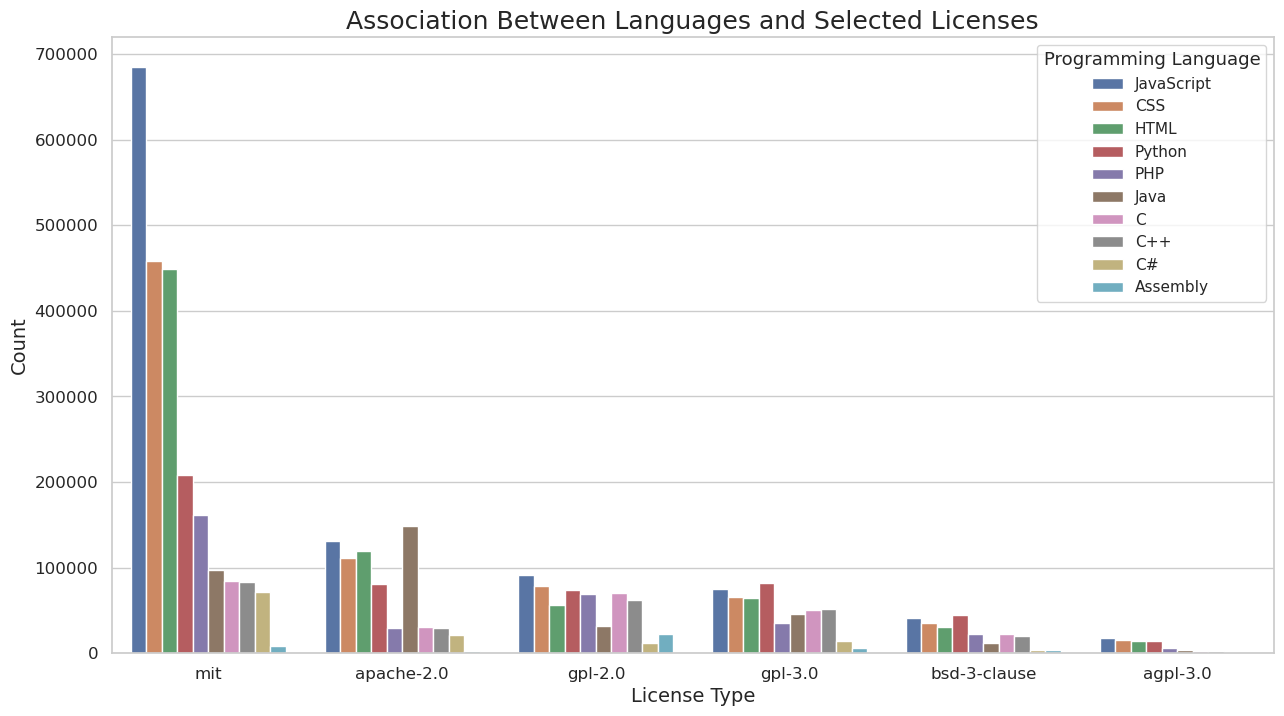

In [21]:
import seaborn as sns

selected_licenses = ["mit", "apache-2.0", "gpl-2.0", "gpl-3.0", "bsd-3-clause", "agpl-3.0"]
filtered_language_license_distribution = association_counts.filter(col("license").isin(selected_licenses))

# Convert Spark DataFrame to Pandas DataFrame for plotting
filtered_language_license_distribution_pd = filtered_language_license_distribution.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))
sns.barplot(x="license", y="count", hue="language_cleaned", data=filtered_language_license_distribution_pd)
plt.title('Association Between Languages and Selected Licenses', fontsize=18)
plt.xlabel('License Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Programming Language', title_fontsize='13')
plt.savefig("license_language_plot.png")
plt.show()

Most of the major programming languages seem to be using mit. However, Java has more counts in apache-2.0 than in mit